# How to use the DETR XAI tool

- Import necessary libraries

In [1]:
from xai_detr.explainer import DetrExplainer
from pathlib import Path
from PIL import Image
from typing import Any, Dict, List, Tuple

import xai_detr.base as base
import transformers as tr
import torch

- In this example we use the DETR model from the `Hugging Face` model hub. We will use the model trained on COCO dataset. 

In [2]:
model = tr.DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", 
    ignore_mismatched_sizes=True)

processor = tr.DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")  # Load the feature extractor for pre and post processing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\transformers\models\detr

- In order to use the explainer, we need to implement the `AbstractDetrModule` interface by overriding the abstract methods, build in a similar way as the `pytorch-lightning`'s `LightningModule` class.
- Take a look at `xai_detr/base.py` for more details on what is required to implement the abstract methods

## Overrding the abstract methods of `AbstractDetrModule`

- Initialize the module with the necessary attributes that are shared across the methods.

In [3]:
class DetrModule(base.AbstractDetrModule):
    
    def __init__(
        self, 
        model: tr.DetrForObjectDetection,
        processor: tr.DetrFeatureExtractor,
    ):
        super().__init__()
        self.model = model
        self.processor = processor

detr_module = DetrModule(model, processor)

- Implement the `preprocess` method 

In [4]:
def _preprocess(self: DetrModule, image: Image.Image, **kwargs) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    encoding = self.processor(
        images=image, 
        annotations={'image_id': 0, 'annotations': []},
        return_tensors="pt")

    pixel_values = encoding["pixel_values"]
    labels = encoding["labels"]
    
    encoding = self.processor.pad(list(pixel_values), return_tensors="pt")
    
    inputs = {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
    }
    
    labels = {
        'original_size': [labels[0]['orig_size']],
    }
    
    return inputs, labels
    
detr_module.preprocess = _preprocess.__get__(detr_module)

- Implement the `predict` method 

In [5]:
def _predict(self: DetrModule, inputs: Dict[str, torch.Tensor], **kwargs) -> base.DetrOutput:
    conv_features = []
    conv_hook = self.model.model.backbone.register_forward_hook(
        lambda m, i, o: conv_features.append(o))
    
    outputs = self.model(**inputs, output_attentions=True)
    
    [(conv_feature_maps, _), ] = conv_features
    conv_feature, _ = conv_feature_maps[-1]
    h, w = conv_feature.squeeze(0).shape[1:]
    conv_hook.remove()
    
    return base.DetrOutput(
        logits=outputs['logits'],
        pred_boxes=outputs['pred_boxes'],
        encoder_attentions=outputs['encoder_attentions'],
        decoder_attentions=outputs['decoder_attentions'],
        cross_attentions=outputs['cross_attentions'],
        conv_feature_shape=(h, w)
    )

detr_module.predict = _predict.__get__(detr_module)

- Implement the `postprocess` method 

In [6]:
def _postprocess(self: DetrModule, outputs: base.DetrOutput, labels: Dict[str, torch.Tensor]) -> List[base.DetectionItem]:
    decoded_outputs = self.processor.post_process_object_detection(
        outputs=outputs, 
        threshold=0.0, 
        target_sizes=labels['original_size'])[0]

    detections = list(zip(
        decoded_outputs['scores'].tolist(), 
        decoded_outputs['labels'].tolist(), 
        decoded_outputs['boxes'].tolist()
    ))

    if len(detections) > 0:
        labels = [self.id2label()[d[1]] for d in detections]
        scores, _, boxes = list(zip(*detections))
        
        detection_items: List[base.DetectionItem] = []
        for s, l, b in zip(scores, labels, boxes):
            detection_items.append(base.DetectionItem(
                score=s, label=l, box=b
            ))
    else:
        detection_items = []
    
    return detection_items

detr_module.postprocess = _postprocess.__get__(detr_module)

- Implement the methods related to the configuration of the model and the dataset on which the model is trained.

In [7]:
def _id2label(self: DetrModule) -> Dict[int, str]:
    return self.model.config.id2label
    
def _no_object_id(self: DetrModule) -> int:
    return len(self.id2label())

def _num_queries(self: DetrModule) -> int:
    return self.model.config.num_queries
 
detr_module.id2label = _id2label.__get__(detr_module)
detr_module.no_object_id = _no_object_id.__get__(detr_module)
detr_module.num_queries = _num_queries.__get__(detr_module)

- Implement other utility methods that are required for the explainer to work.

In [8]:
def _to(self: DetrModule, device: torch.device):
    self.model = self.model.to(device)
    return self

def _requires_grad(self: DetrModule, requires_grad: bool):
    self.model.requires_grad_(requires_grad)

def _freeze_backbone(self: DetrModule):
    self.model.model.freeze_backbone()
    
def _zero_grad(self: DetrModule):
    self.model.zero_grad()

detr_module.to = _to.__get__(detr_module)
detr_module.requires_grad = _requires_grad.__get__(detr_module)
detr_module.freeze_backbone = _freeze_backbone.__get__(detr_module)
detr_module.zero_grad = _zero_grad.__get__(detr_module)

- Intialize the explainer with the custom model and the device.

In [9]:
detr_explainer = DetrExplainer(model=detr_module, device=device)

-  Loop through the images and generate the explanation for each image.

In [10]:
for img_path in Path(r'./resources/images/coco').glob('*.jpg'):
    img = Image.open(img_path)
    detr_explainer.explain(
        image=img,
        include_labels='all',
        threshold=0.9,
        output_dir=Path(r'./explanations/') / img_path.stem)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


- Load an explanation for one image

In [11]:
from xai_detr.visualization_utils import *

explainer_output = base.DetrExplainerOutput.load(Path(r'./explanations/cat/explanations.pkl'))

In [33]:
exp_iter = iter(explainer_output.explanations)

C:\Users\snovi\AppData\Local\Temp\ipykernel_32524\3536394029.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


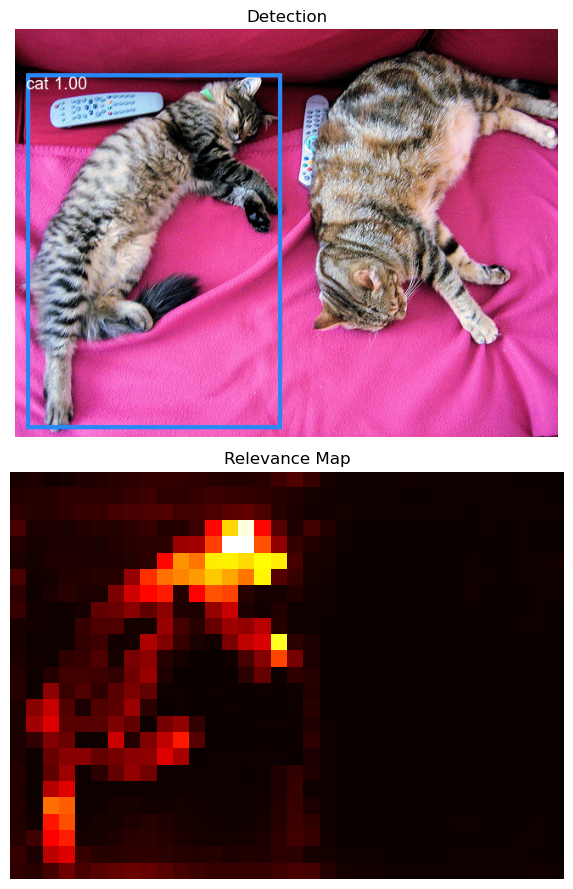

In [35]:
exp_item = next(exp_iter)

figure = plot_detection_and_relevance_map(
    image=explainer_output.image,
    detection=exp_item.detection,
    relevance_map=exp_item.relevance_map,
)

figure.show()